# 使用回归方法预测行星尺寸
这是一个根据kaggle上行星数据集预测行星尺寸的数据预测分析笔记本。
## 0.引入包

In [136]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

## 1. 原始数据加载

In [137]:
df = pd.read_csv('./Asteroid_Updated.csv')

/var/folders/hb/9qr23dms0lg2_mgzzyhsqyhh0000gn/T/ipykernel_1482/32122648.py:1: DtypeWarning: Columns (0,10,15,16,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./Asteroid_Updated.csv')


### 数据格式展示
下面展示数据的一些样例。

In [138]:
df.head()

,name,a,e,i,om,w,q,ad,per_y,data_arc,...,UB,IR,spec_B,spec_T,G,moid,class,n,per,ma
0,Ceres,2.769165,0.076009,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,8822.0,...,0.426,NaN,C,G,0.12,1.59478,MBA,0.213885,1683.145708,77.372096
1,Pallas,2.772466,0.230337,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,72318.0,...,0.284,NaN,B,B,0.11,1.23324,MBA,0.213503,1686.155999,59.699133
2,Juno,2.669150,0.256942,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,72684.0,...,0.433,NaN,Sk,S,0.32,1.03454,MBA,0.226019,1592.787285,34.925016
3,Vesta,2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,24288.0,...,0.492,NaN,V,V,0.32,1.13948,MBA,0.271609,1325.432765,95.861936
4,Astraea,2.574249,0.191095,5.366988,141.576605,358.687607,2.082324,3.066174,4.130323,63507.0,...,0.411,NaN,S,S,NaN,1.09589,MBA,0.238632,1508.600458,282.366289


### 数据的列展示

In [139]:
df.columns

Index(['name', 'a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc',
       'condition_code', 'n_obs_used', 'H', 'neo', 'pha', 'diameter', 'extent',
       'albedo', 'rot_per', 'GM', 'BV', 'UB', 'IR', 'spec_B', 'spec_T', 'G',
       'moid', 'class', 'n', 'per', 'ma'],
      dtype='object')

### 展示缺失数据

In [140]:
missing= pd.concat([pd.isnull(df).sum(), 100 * pd.isnull(df).mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by=['count'])

,count,%
e,0,0.000000
i,0,0.000000
om,0,0.000000
w,0,0.000000
q,0,0.000000
class,0,0.000000
n_obs_used,0,0.000000
per_y,1,0.000119
a,2,0.000238
n,2,0.000238


### 展示可以用于学习的总行数

In [141]:
valid_rows = df['diameter'].notnull().sum()
valid_rows

137636

### 删除diameter元素为空的行

In [142]:
df = df.dropna(axis=0,subset=['diameter'])

len(df.index)

137636

### 摘除无效数据之后的数据值

In [143]:
missing= pd.concat([pd.isnull(df).sum(), 100 * pd.isnull(df).mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by=['count'])

,count,%
diameter,0,0.000000
n,0,0.000000
class,0,0.000000
moid,0,0.000000
per,0,0.000000
pha,0,0.000000
neo,0,0.000000
n_obs_used,0,0.000000
condition_code,0,0.000000
ma,0,0.000000


### 继续摘除无效的原始数据

In [144]:
drop_list = ['H','albedo','name','rot_per','spec_B',
             'BV','spec_T','UB','G',
             'extent','GM','IR']
# df.drop(drop_list, axis=1, inplace=True)
len(df.columns)

19

### 得到最终需要处理的数据组

In [145]:
df.dtypes

a                 float64
e                 float64
i                 float64
om                float64
w                 float64
q                 float64
ad                float64
per_y             float64
data_arc          float64
condition_code     object
n_obs_used          int64
neo                object
pha                object
diameter           object
moid              float64
class              object
n                 float64
per               float64
ma                float64
dtype: object

## 2.特征工程

### 对`object`对象进行特征工程

In [146]:
df.select_dtypes('object').tail()

,condition_code,neo,pha,diameter,class
797860,1,N,N,3.793,MBA
798077,2,N,N,2.696,MBA
798189,1,N,N,2.917,MBA
799752,2,N,N,3.271,MBA
810375,3,N,N,1.6,MBA


In [147]:
# 处理diameter
# 由于原始数据出现有一行格式不统一，在转换的时候需要重新处理这一行的数据，便于运用pd的to_numeric函数
df.at[15,'diameter'] = 226
df['diameter'] = pd.to_numeric(df['diameter'])

In [148]:
# 处理condition_code
# 下面将这个数据段的内容读取出来换成唯一的数据值
df['condition_code'] = df['condition_code'].astype('int64')

df.condition_code.unique()

array([0, 1, 3, 2, 4, 5, 9, 7, 6, 8])

In [149]:
# 处理neo 原始只有N和Y两组
df.neo.unique()
df['neo'].value_counts()

neo
N    136786
Y       850
Name: count, dtype: int64

In [150]:
# 处理pha，原始只有N和Y两组
df.pha.unique()
df['pha'].value_counts()

pha
N    137415
Y       221
Name: count, dtype: int64

In [151]:
df['class'].unique()
df['class'].value_counts()

class
MBA    126390
OMB      7510
TJN      1874
IMB       588
APO       486
MCA       355
AMO       269
ATE        95
CEN        49
TNO        13
AST         7
Name: count, dtype: int64

### 展示整数特征
主要消除非正常类型对机器学习的影响。

In [152]:
df.select_dtypes('int64')

,condition_code,n_obs_used
0,0,1002
1,0,8490
2,0,7104
3,0,9325
4,0,2916
...,...,...
797860,1,50
798077,2,33
798189,1,47
799752,2,27


### 展示浮点数特征
主要消除正常类型对机器学习的影响。

In [153]:
df.select_dtypes('float64')

,a,e,i,om,w,q,ad,per_y,data_arc,diameter,moid,n,per,ma
0,2.769165,0.076009,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,8822.0,939.400,1.59478,0.213885,1683.145708,77.372096
1,2.772466,0.230337,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,72318.0,545.000,1.23324,0.213503,1686.155999,59.699133
2,2.669150,0.256942,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,72684.0,246.596,1.03454,0.226019,1592.787285,34.925016
3,2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,24288.0,525.400,1.13948,0.271609,1325.432765,95.861936
4,2.574249,0.191095,5.366988,141.576605,358.687607,2.082324,3.066174,4.130323,63507.0,106.699,1.09589,0.238632,1508.600458,282.366289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797860,3.171225,0.159119,27.098625,309.036573,19.746812,2.666623,3.675826,5.647402,2373.0,3.793,1.66301,0.174527,2062.713583,164.999439
798077,2.548410,0.076071,11.593237,246.298656,170.090810,2.354549,2.742270,4.068291,3297.0,2.696,1.36733,0.242270,1485.943371,145.319581
798189,3.146246,0.220559,17.966646,137.981403,180.898832,2.452313,3.840180,5.580811,2839.0,2.917,1.43837,0.176610,2038.391053,174.609920
799752,3.051336,0.287449,14.456779,343.917822,342.614839,2.174231,3.928440,5.330196,2208.0,3.271,1.16684,0.184914,1946.853973,175.708508


### 参数分布
使用pd的`df`内置的函数`hist`对于数据中的各个表单项目进行绘制

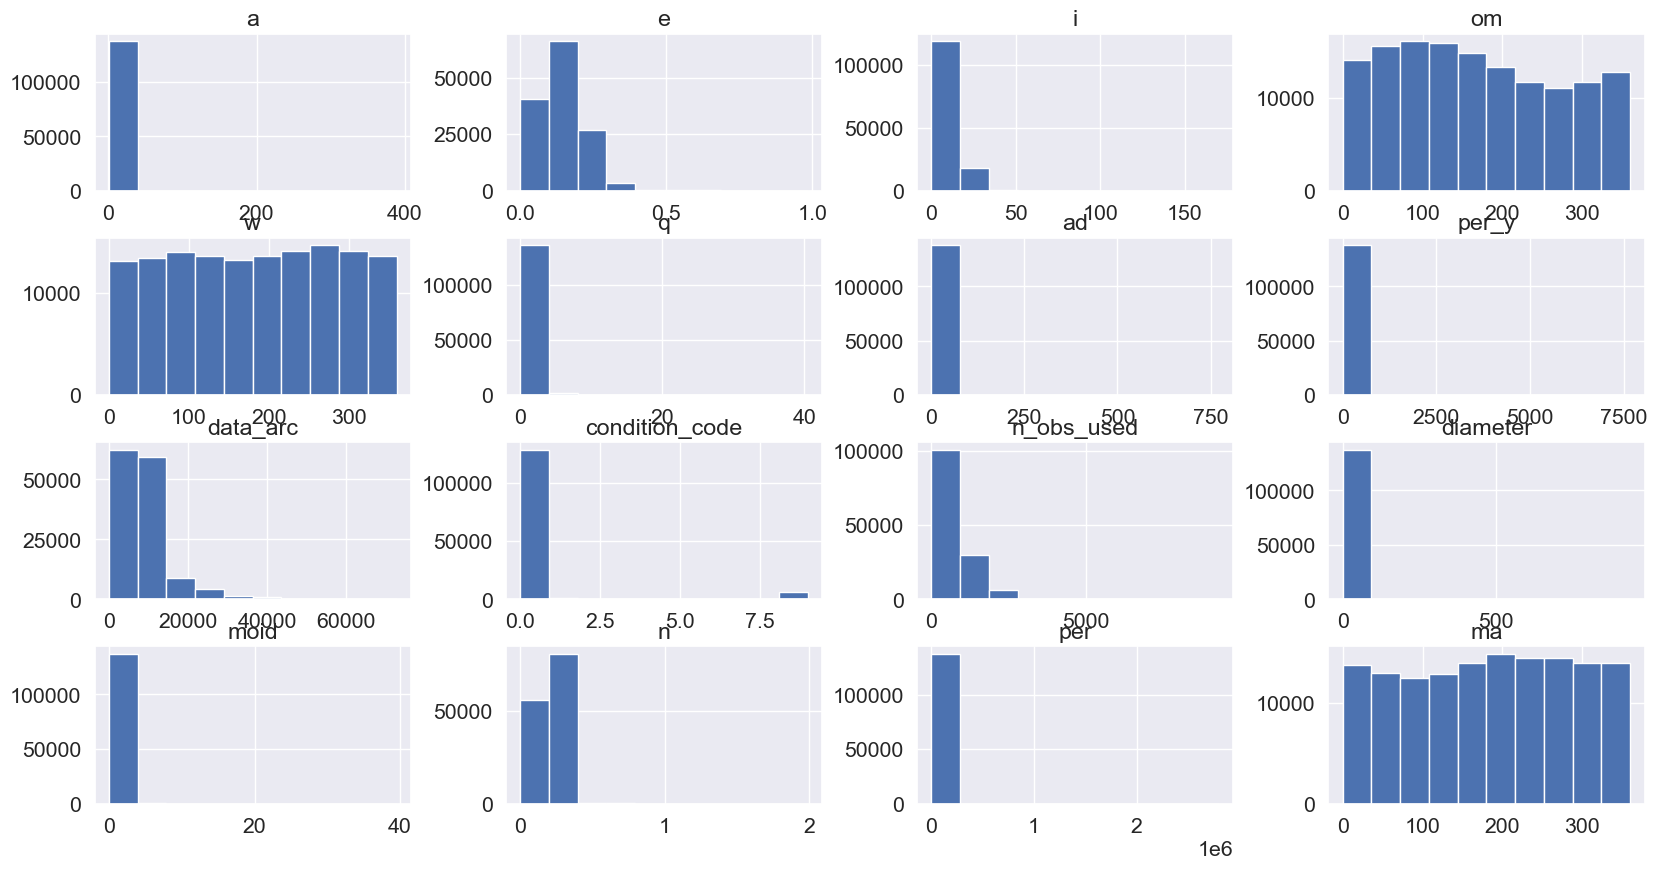

In [154]:
df.hist(figsize=(20,10))
plt.show()

使用`seaborn`库的箱线图绘制方法,对`DataFrame`中的`data_arc`列进行可视化,绘制出箱线图。

箱线图能直观地显示出这一列数据的四分位数范围、上下限范围和异常值,用于快速理解该列数据的分布情况。

<Axes: >

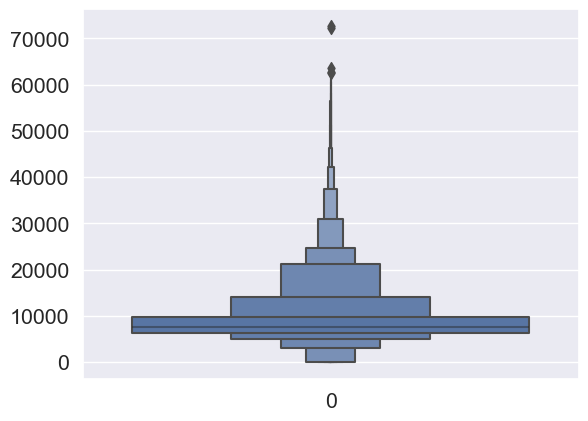

In [155]:
sns.boxenplot(df['data_arc'])

用数据的中位数来补全那些缺失的数据。

In [156]:
df['data_arc'] = df['data_arc'].fillna(df['data_arc'].median())

最终得到整数和浮点数的特征工程后的结果。

In [157]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
a,137636.0,2.814613,1.522740,0.626226,2.536714,2.750859,3.092537,3.891460e+02
e,137636.0,0.145485,0.077573,0.000489,0.089623,0.138543,0.191141,9.843482e-01
i,137636.0,10.349182,6.835111,0.021855,5.120506,9.389963,13.738588,1.703236e+02
om,137636.0,169.827629,102.713052,0.000738,82.334880,160.438430,256.268387,3.599909e+02
w,137636.0,181.904551,103.556464,0.004466,91.947943,183.669900,271.762261,3.599952e+02
q,137636.0,2.402609,0.516169,0.081882,2.068948,2.363897,2.685811,4.046567e+01
ad,137636.0,3.226618,2.896374,0.999956,2.864438,3.167516,3.468608,7.722011e+02
per_y,137636.0,4.884248,25.532565,0.495569,4.040317,4.562581,5.438518,7.676743e+03
data_arc,137636.0,8968.417086,6162.243453,1.000000,6292.000000,7572.000000,9726.000000,7.268400e+04
condition_code,137636.0,0.485207,1.966078,0.000000,0.000000,0.000000,0.000000,9.000000e+00


In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137636 entries, 0 to 810375
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   a               137636 non-null  float64
 1   e               137636 non-null  float64
 2   i               137636 non-null  float64
 3   om              137636 non-null  float64
 4   w               137636 non-null  float64
 5   q               137636 non-null  float64
 6   ad              137636 non-null  float64
 7   per_y           137636 non-null  float64
 8   data_arc        137636 non-null  float64
 9   condition_code  137636 non-null  int64  
 10  n_obs_used      137636 non-null  int64  
 11  neo             137636 non-null  object 
 12  pha             137636 non-null  object 
 13  diameter        137636 non-null  float64
 14  moid            137636 non-null  float64
 15  class           137636 non-null  object 
 16  n               137636 non-null  float64
 17  per            

In [159]:
data_type = df.dtypes
data_type[(data_type=='object')|(data_type=='category')].index.tolist()

['neo', 'pha', 'class']

由于`neo`和`pha`对于实际的回归没有用处，选择丢弃这两个特征。

In [160]:
drop_list = ['neo','pha']
df.drop(drop_list,axis=1,inplace=True)

下面针对`class`属性做进一步的研究。

In [161]:
df['class'] = df['class'].astype('category')
df['class'].dtypes

CategoricalDtype(categories=['AMO', 'APO', 'AST', 'ATE', 'CEN', 'IMB', 'MBA', 'MCA',
                  'OMB', 'TJN', 'TNO'],
, ordered=False, categories_dtype=object)

In [162]:
sns.set_palette('inferno',11)

展示不同`class`对小行星尺寸的影响。

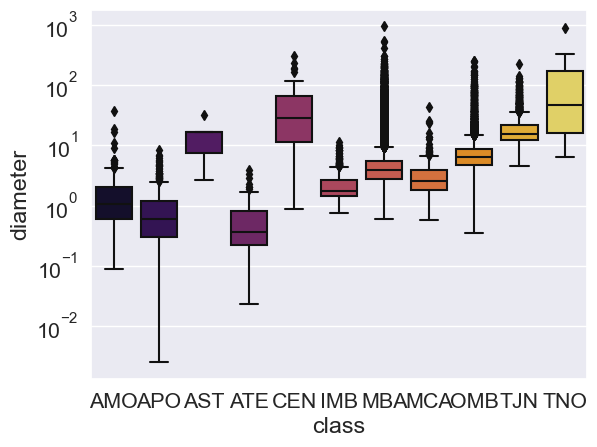

In [163]:
sns.boxplot(x='class',y='diameter',data=df)
plt.yscale('log')

In [164]:
df['diameter'].describe()

count    137636.000000
mean          5.483228
std           9.385735
min           0.002500
25%           2.770000
50%           3.956000
75%           5.742000
max         939.400000
Name: diameter, dtype: float64

从`class`中`diameter`的分布看对应的`diameter`影响

In [165]:
class_group = df.groupby('class').agg({
    'diameter':['mean','median','min','max','std','var','count']
})
print(class_group)

         diameter                                                            
             mean   median     min      max         std           var   count
class                                                                        
AMO      1.766591   1.0450  0.0880   37.675    2.971932      8.832382     269
APO      0.958425   0.6025  0.0025    8.480    1.097541      1.204597     486
AST     14.283429  16.4000  2.6560   32.492   10.028549    100.571796       7
ATE      0.630716   0.3700  0.0230    3.879    0.702853      0.494002      95
CEN     52.473245  28.0000  0.8900  302.000   63.978581   4093.258785      49
IMB      2.288675   1.7460  0.7420   11.506    1.470614      2.162706     588
MBA      5.076341   3.8340  0.6000  939.400    8.277078     68.510018  126390
MCA      3.411217   2.5570  0.5870   42.870    3.512911     12.340547     355
OMB      8.783017   6.3565  0.3470  254.000   12.023403    144.562224    7510
TJN     20.771467  15.4710  4.5620  225.000   16.487683    271.8

`Condition Code`部分

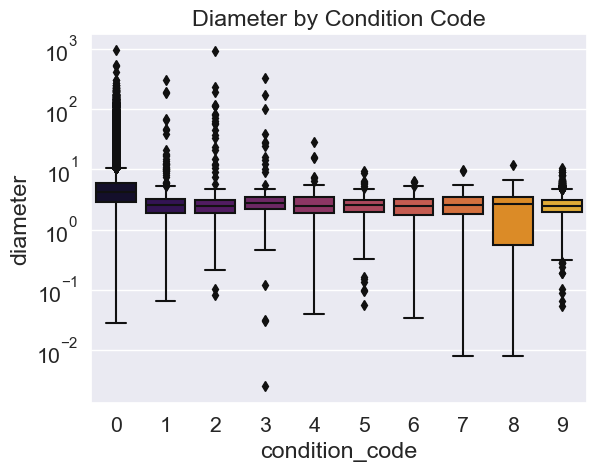

In [166]:
sns.boxplot(x='condition_code', y='diameter', data=df)
plt.title('Diameter by Condition Code')
plt.yscale('log');

In [167]:
df.columns

Index(['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc',
       'condition_code', 'n_obs_used', 'diameter', 'moid', 'class', 'n', 'per',
       'ma'],
      dtype='object')

In [168]:
df.drop('condition_code',axis=1,inplace=True)
# df.drop('class',axis=1,inplace=True)

研究数值特征之间的关系。(problem here)

In [169]:
plt.figure(figsize=(20,10))
sns.set(font_scale=1.4)
sns.heatmap(df.corr(),annot=True, cmap='inferno', fmt='.2f', annot_kws={'size':14});

ValueError: could not convert string to float: 'MBA'

<Figure size 2000x1000 with 0 Axes>

In [170]:
df.drop('per_y',axis=1,inplace=True)
df.drop('moid',axis=1,inplace=True)

In [171]:
df.select_dtypes(include=['object']).head().T

,0,1,2,3,4


In [172]:
df = pd.get_dummies(df,columns=['class'])

In [173]:
df.columns

Index(['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'data_arc', 'n_obs_used',
       'diameter', 'n', 'per', 'ma', 'class_AMO', 'class_APO', 'class_AST',
       'class_ATE', 'class_CEN', 'class_IMB', 'class_MBA', 'class_MCA',
       'class_OMB', 'class_TJN', 'class_TNO'],
      dtype='object')

## 3.训练前准备工作
### 划分训练集和测试集

In [175]:
from sklearn.model_selection import train_test_split
predictors = df.drop('diameter',axis=1)
target =  df['diameter']
X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)

In [176]:
X_train.head()

,a,e,i,om,w,q,ad,data_arc,n_obs_used,n,...,class_APO,class_AST,class_ATE,class_CEN,class_IMB,class_MBA,class_MCA,class_OMB,class_TJN,class_TNO
148020,2.726194,0.266986,8.078396,94.580422,291.214105,1.998338,3.454050,7940.0,341,0.218962,...,False,False,False,False,False,True,False,False,False,False
241053,2.771711,0.079738,5.065503,49.562697,297.001221,2.550701,2.992720,9339.0,291,0.213591,...,False,False,False,False,False,True,False,False,False,False
625000,3.210080,0.083664,3.653610,141.677454,309.154612,2.941511,3.478649,1.0,13,0.171368,...,False,False,False,False,False,False,False,True,False,False
304501,2.978885,0.033621,3.364579,103.027400,227.734228,2.878731,3.079038,5479.0,100,0.191701,...,False,False,False,False,False,True,False,False,False,False
59497,2.470771,0.099896,24.383685,201.171239,331.721958,2.223951,2.717592,7522.0,1128,0.253779,...,False,False,False,False,False,True,False,False,False,False


### 数据正则化

In [177]:
from sklearn import preprocessing

std_scaler = preprocessing.StandardScaler().fit(X_train)

def scaler(X):
    x_norm_arr = std_scaler.fit_transform(X)
    return pd.DataFrame(x_norm_arr,columns=X.columns,index=X.index)

X_train_norm = scaler(X_train)
X_test_norm =  scaler(X_test)

def inverse_scaler(X):
    x_norm_arr= std_scaler.inverse_transform(X)
    return pd.DataFrame(x_norm_arr, columns=X.columns, index = X.index)